In [7]:
import numpy as np
import matplotlib.pyplot as plt

    fjac: array([[-0.02290907,  0.04067244, -0.99890987],
       [-0.99971279,  0.00610017,  0.02317587],
       [ 0.00703614,  0.99915391,  0.04052101]])
     fun: array([-0.16898082,  0.00025071, -0.00616086])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 153
     qtf: array([ 0.01003553,  0.16879103, -0.00118812])
       r: array([ 5.85191658e+01,  3.40918087e+01,  8.45959487e-08, -1.73353701e-01,
       -5.69344922e-10, -7.08691372e-11])
  status: 5
 success: False
       x: array([ 3.50295642e+00, -4.06986281e+00,  2.71780866e+11])
-0.1689813966128748 -0.00616104027917963


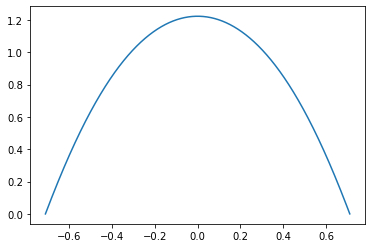

In [282]:
from scipy.optimize import root
from scipy.integrate import solve_ivp

def dddf(t,y,q,nu):
    return [y[1],
            y[2],
            2*q/nu*y[1]*y[0]-4*y[1]]


def conditions(x,b,q,nu):
    res = solve_ivp(dddf,(-b, b),[0,x[0],x[1]],args=(q,nu),max_step=0.001)
    return [1-np.trapz(res.y[0],res.t),
            res.y[0][-1],
           np.sum(np.interp(np.linspace(-b,0),res.t,res.y[0])
                  -np.interp(np.linspace(0,b),res.t,res.y[0]))]

bounds=0.71
q = 3
nu = 1
r = root(conditions,[10,-22,0],args=(bounds,q,nu))
print(r)
res = solve_ivp(dddf,(-bounds, bounds),[0,r.x[0],r.x[1]],args=(q,nu),max_step=0.0001)
plt.plot(res.t,res.y[0])
print(1-np.trapz(res.y[0],res.t),np.sum(np.interp(np.linspace(-bounds,0),res.t,res.y[0])-np.interp(np.linspace(0,bounds),res.t,res.y[0])))

Text(0, 0.5, 'error')

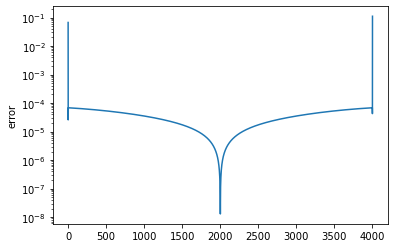

In [165]:
#Check that integral is correct

plt.semilogy(np.abs(np.gradient(res.y[2],res.t) - (2*res.y[0]-4)*res.y[1]))
plt.ylabel("error")

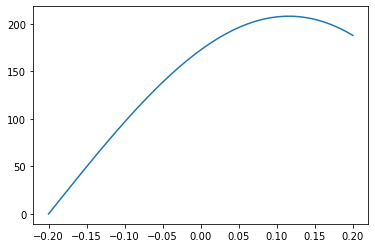

In [72]:
res = solve_ivp(dddf,(-0.2, 0.2),[0,-10,1000],args=(1,1),max_step=0.01)
plt.plot(res.t,res.y[0])
#np.sum(np.interp(np.linspace(-0.2,0),res.t,res.y[0])-np.interp(np.linspace(0,0.2),res.t,res.y[0]))

1.0681498135873182 2.3576214419439827


0.7853981633974483

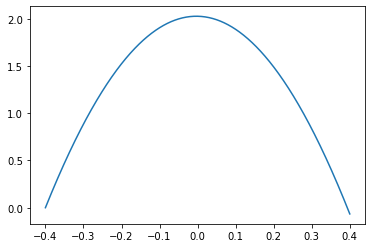

In [271]:
res = solve_ivp(dddf,(-0.40, 0.40),[0,10,-22],args=(1,1),max_step=0.001)
plt.plot(res.t,res.y[0])
print(np.trapz(res.y[0],res.t),np.sum(np.interp(np.linspace(-bounds,0),res.t,res.y[0])-np.interp(np.linspace(0,bounds),res.t,res.y[0])))
np.pi/4